In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
import torchvision
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torchvision import datasets, models, transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import time
import copy
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [74]:
class LyftUdacity(Dataset):
    def __init__(self,img_dir,transform = None):
        self.transforms = transform
        image_paths = [i+'/CameraRGB' for i in img_dir]
        seg_paths = [i+'/CameraSeg' for i in img_dir]
        self.images,self.masks = [],[]
        for i in image_paths:
            imgs = os.listdir(i)
            self.images.extend([i+'/'+img for img in imgs])
        for i in seg_paths:
            masks = os.listdir(i)
            self.masks.extend([i+'/'+mask for mask in masks])
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img = np.array(Image.open(self.images[index]))
        mask = np.array(Image.open(self.masks[index]))
        if self.transforms is not None:
            aug = self.transforms(image=img,mask=mask)
            img = aug['image']
            mask = aug['mask']
            tr = transforms.Resize(size = (164, 164))
            mask = tr(mask.permute(2, 0, 1))
            mask = torch.max(mask,dim=0)[0]
        return img,mask

In [75]:
data_dir = ['./data'+i+'/data'+i for i in ['A']]

In [76]:
def get_images(image_dir,transform = None,batch_size=16,shuffle=True,pin_memory=True):
    data = LyftUdacity(image_dir,transform = t1)
    train_size = int(0.8 * data.__len__())
    test_size = data.__len__() - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
    train_batch = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    test_batch = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    return train_batch,test_batch


In [77]:
t1 = A.Compose([
    A.Resize(256, 256),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [78]:
train_batch,test_batch = get_images(data_dir,transform =t1,batch_size=16)

In [79]:
img, mask = next(iter(train_batch))

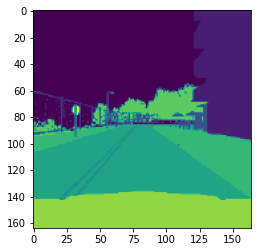

In [80]:
plt.imshow(mask[0].view(1, 164, 164).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


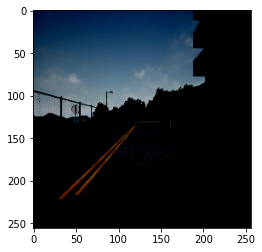

In [81]:
plt.imshow(img[0].view(3, 256, 256).permute(1, 2, 0))

### MODEL

In [82]:
class UNetDown(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(UNetDown, self).__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, 3)
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x_1 = x.detach().clone()
        x = self.pool(x)
        return x_1, x

In [83]:
class UNetUp(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(UNetUp, self).__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, 3)
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3)
        self.convup = nn.ConvTranspose2d(channels_out, channels_out//2, 2, 2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.convup(x)
        return x

In [84]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.unetdown1 = UNetDown(3, 32)
        self.unetdown2 = UNetDown(32, 64)
        self.unetdown3 = UNetDown(64, 128)
        self.conv1 = nn.Conv2d(128, 256, 3)
        self.conv2 = nn.Conv2d(256, 256, 3)
        self.convup1 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.relu = nn.ReLU()
        self.trans1 = transforms.CenterCrop(48)
        self.trans2 = transforms.CenterCrop(88)
        self.trans3 = transforms.CenterCrop(168)
        self.unetup1 = UNetUp(256, 128)
        self.unetup2 = UNetUp(128, 64)
        self.conv3 = nn.Conv2d(64, 32, 3)
        self.conv4 = nn.Conv2d(32, 32, 3)
        self.conv5 = nn.Conv2d(32, 13, 1)
    
    def forward(self, x):
        x1, x = self.unetdown1(x)
        x2, x = self.unetdown2(x)
        x3, x = self.unetdown3(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.convup1(x)
        x = torch.cat((self.trans1(x3), x), 1)
        x = self.unetup1(x)
        x = torch.cat((self.trans2(x2), x), 1)
        x = self.unetup2(x)
        x = torch.cat((self.trans3(x1), x), 1)                  
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x
        
#256-254-252 -- 32
#126-124-122 -- 64
#61-59-57 --128
#28-26-24 -- 256
#48-46-44 -- 128
#88-86-84 -- 64
#168-166-164-164 -- 1

In [85]:
model = UNet().to(device)

In [104]:
lr = 1e-3
num_epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [105]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_batch),total=len(train_batch))
    for batch_idx, (data, targets) in loop:
        data = data.to(device)
        targets = targets.to(device)
        targets = targets.type(torch.long)
        # forward
        predictions = model(data)
        loss = loss_fn(predictions, targets)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

  8%|▊         | 4/50 [00:19<03:45,  4.90s/it, loss=3.38] 


KeyboardInterrupt: 

In [90]:
def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x)),axis=1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

In [95]:
check_accuracy(train_batch, model)


Got 16789215/21516800 with acc 78.03
Dice score: 7.587718486785889


In [96]:
check_accuracy(test_batch, model)

Got 4184229/5379200 with acc 77.79
Dice score: 7.556795597076416


16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

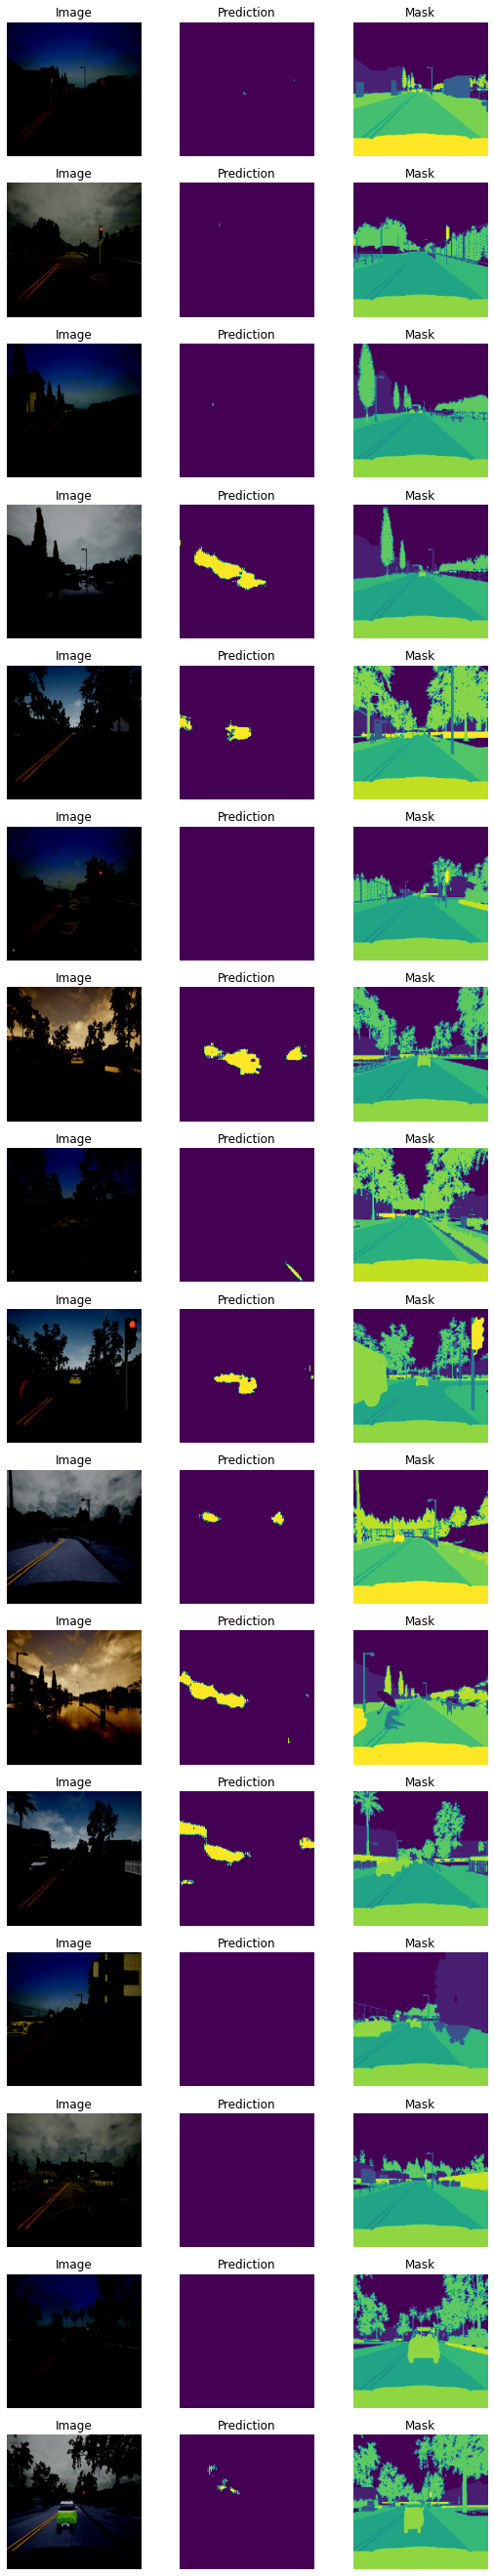

In [106]:
x,y = next(iter(test_batch))
x = x.to(device)
fig , ax =  plt.subplots(16, 3, figsize=(9, 48))
print(len(ax))
softmax = nn.Softmax(dim=1)
preds = torch.argmax(softmax(model(x)),axis=1).to('cpu')
img = []
pred = []
masks = []
for i in range(16):
    img.append(np.transpose(np.array(x[i,:,:,:].to('cpu')),(1,2,0)))
    pred.append(np.array(preds[i,:,:]))
    masks.append(np.array(y[i,:,:]))
for i in range(16):
    ax[i,0].set_title('Image')
    ax[i,1].set_title('Prediction')
    ax[i,2].set_title('Mask')   
    for j in range(3):
        ax[i][j].axis("off")

for i in range(16):
    ax[i][0].imshow(img[i])
    ax[i][1].imshow(pred[i])
    ax[i][2].imshow(masks[i])  